# Import libraries

In [1]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams['figure.dpi'] = 100

# Load a phantom

In [2]:
# mr0.generate_brainweb_phantoms("phantom", "3T") # Just load the first phantom is enough

VoxelGridPhantom
size = tensor([0.1810, 0.2170, 0.1810])


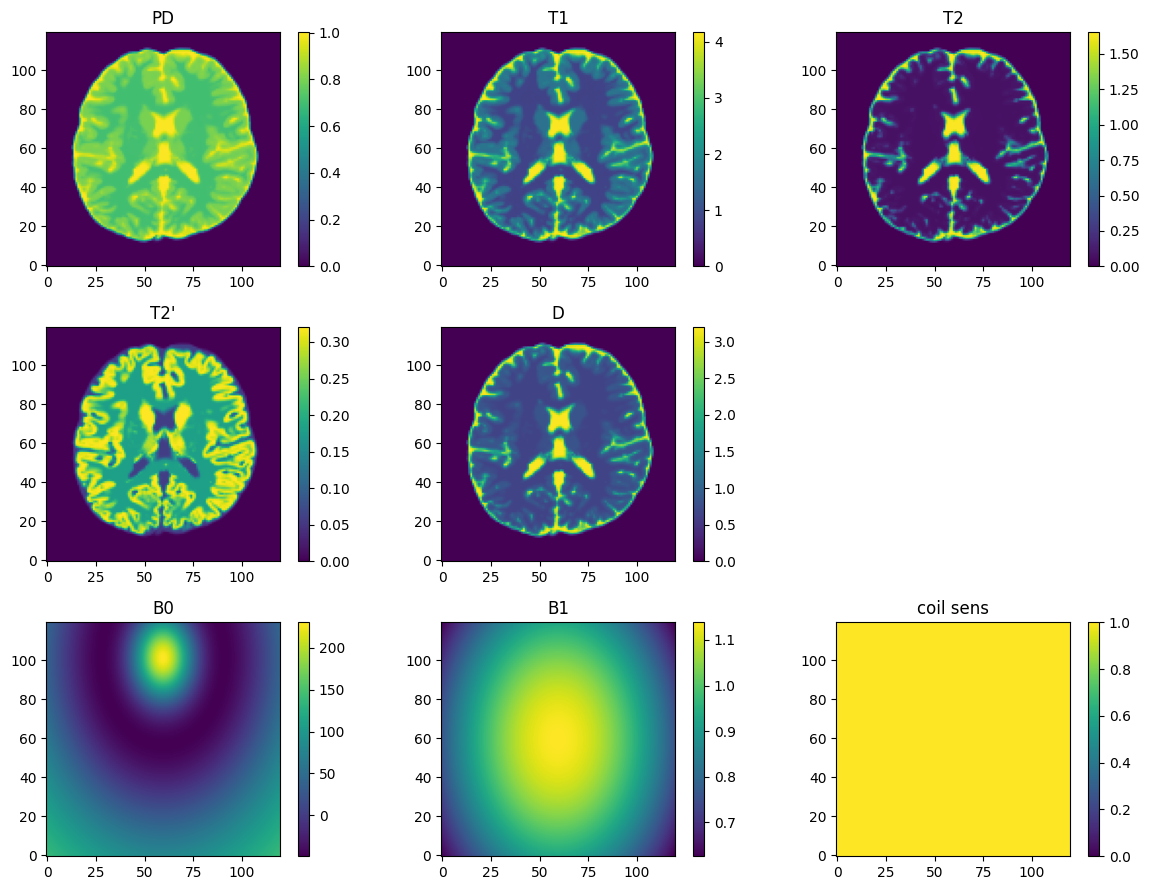

In [30]:
phantom_size = 120
phantom = mr0.VoxelGridPhantom.load("phantom/subject54_3T.npz")
phantom = phantom.interpolate(phantom_size, phantom_size, 1)
data = phantom.build()
phantom.B0*=5
phantom.plot()

# Load a Pulseq file, then do simulation and reconstruction

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.001815567 s
Compute Graph
Computing Graph: 0.14587733 s
Analyze Graph
Analyzing Graph: 0.003551324 s
Converting Rust -> Python: 0.16619748 s
<<<< Rust <<<<


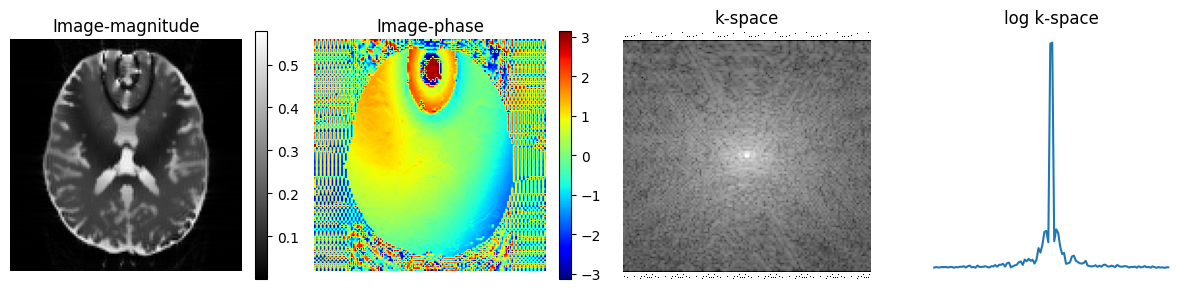

In [31]:
seq_path = "seq/seq_bssfp.seq"

seq = pp.Sequence()
seq.read(seq_path)
signal, _ = mr0.util.simulate(seq, phantom)

k_space = signal.reshape(phantom_size, -1)
spectrum = torch.fft.ifftshift(k_space)
space = torch.fft.ifft2(spectrum)
space = torch.fft.fftshift(space)

# Plot the result
fraction = 0.05

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].set_title('Image-magnitude')
ax0 = axes[0].imshow(np.abs(space.numpy()), cmap="gray")
fig.colorbar(ax0, ax=axes[0], fraction=fraction)

axes[1].set_title('Image-phase')
ax1 = axes[1].imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap="jet")
fig.colorbar(ax1, ax=axes[1], fraction=fraction)

axes[2].set_title('k-space')
ax2 = axes[2].imshow(np.abs(k_space.numpy()), cmap="gray", norm=LogNorm())

axes[3].set_title('log k-space')
# ax3 = axes[3].imshow(np.log(np.abs(k_space.numpy())), cmap=cmap)
# ax3 = axes[3].imshow(np.abs(k_space.numpy()), cmap="grya", norm=LogNorm())
ax3 = axes[3].plot(np.abs(k_space.numpy())[k_space.shape[0]//2,:])

for ax in axes:
    ax.axis("off")

fig.tight_layout()

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.001620312 s
Compute Graph
Computing Graph: 5.756682 s
Analyze Graph
Analyzing Graph: 0.067328855 s
Converting Rust -> Python: 1.837398 s
<<<< Rust <<<<


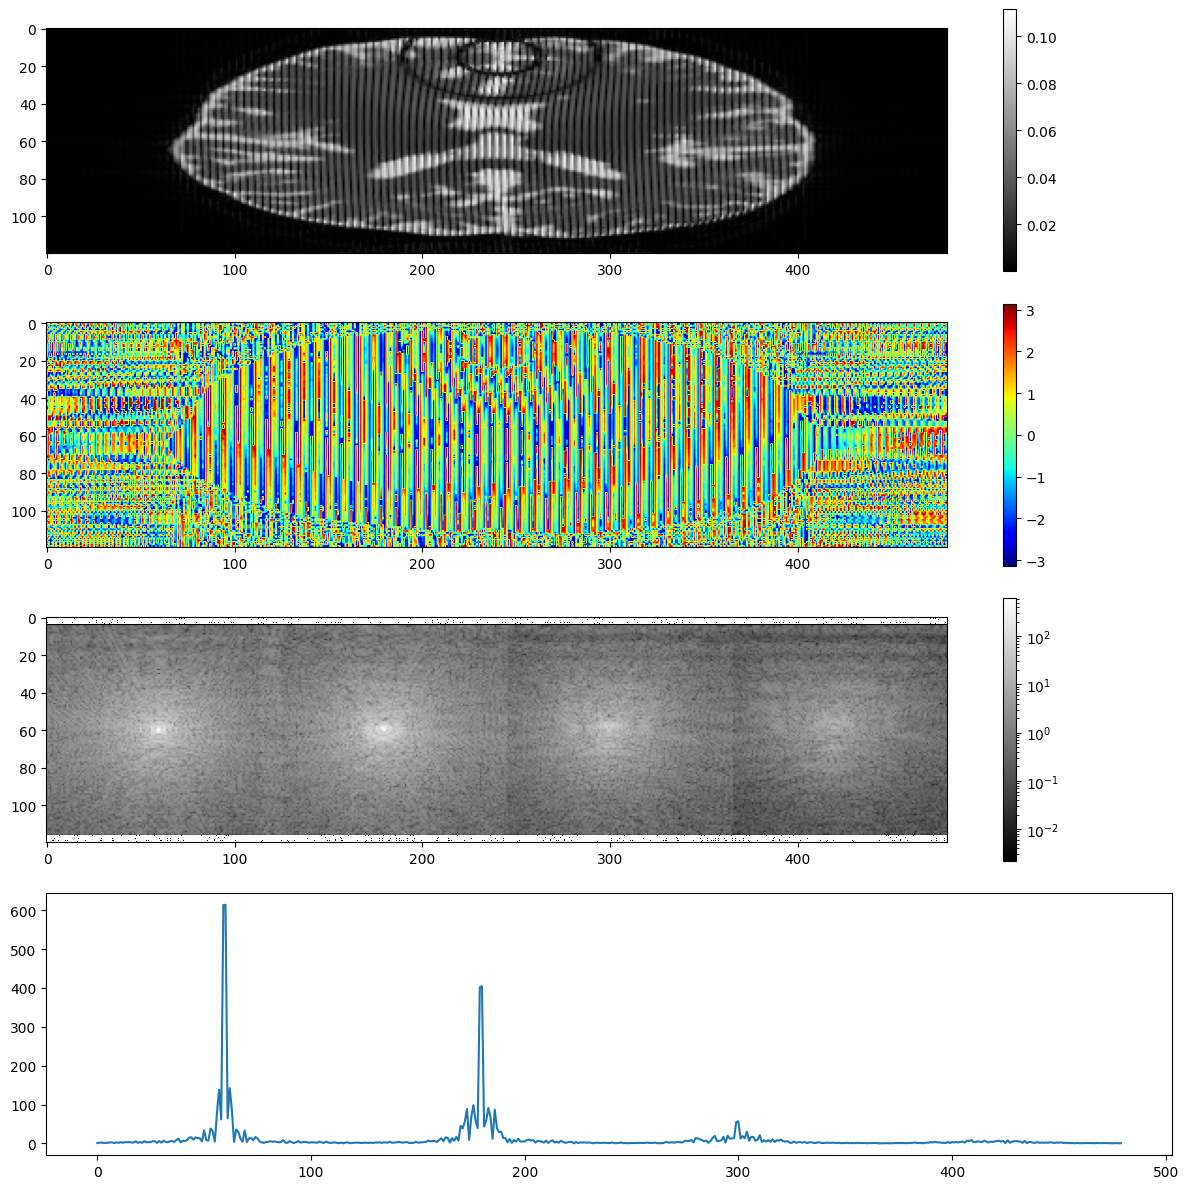

In [32]:
# seq_path = "seq/seq_p1n2.seq"
seq_path = "seq/seq_0n3.seq"

seq = pp.Sequence()
seq.read(seq_path)
signal, _ = mr0.util.simulate(seq, phantom)

# k_space_size = np.sqrt(signal.size()[0]).astype(int)
# DESS
# k_space_size = np.sqrt(signal.size()[0]/2).astype(int)
# print(rf"K space size: {k_space_size}")
# print(signal.size())
# k_space = signal.reshape(k_space_size, k_space_size)
k_space = signal.reshape(phantom_size, -1)
spectrum = torch.fft.ifftshift(k_space)
space = torch.fft.ifft2(spectrum)
space = torch.fft.fftshift(space)

# Plot the result
fraction = 0.05

plt.figure(figsize=(12, 12))
plt.subplot(4,1,1)
plt.imshow(np.abs(space.numpy()), cmap="gray")
plt.colorbar()

plt.subplot(4,1,2)
plt.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap="jet")
plt.colorbar()

plt.subplot(4,1,3)
plt.imshow(np.abs(k_space.numpy()), cmap="gray", norm=LogNorm())
plt.colorbar()

plt.subplot(4,1,4)
plt.plot(np.abs(k_space.numpy())[k_space.shape[0]//2,:])

plt.tight_layout()

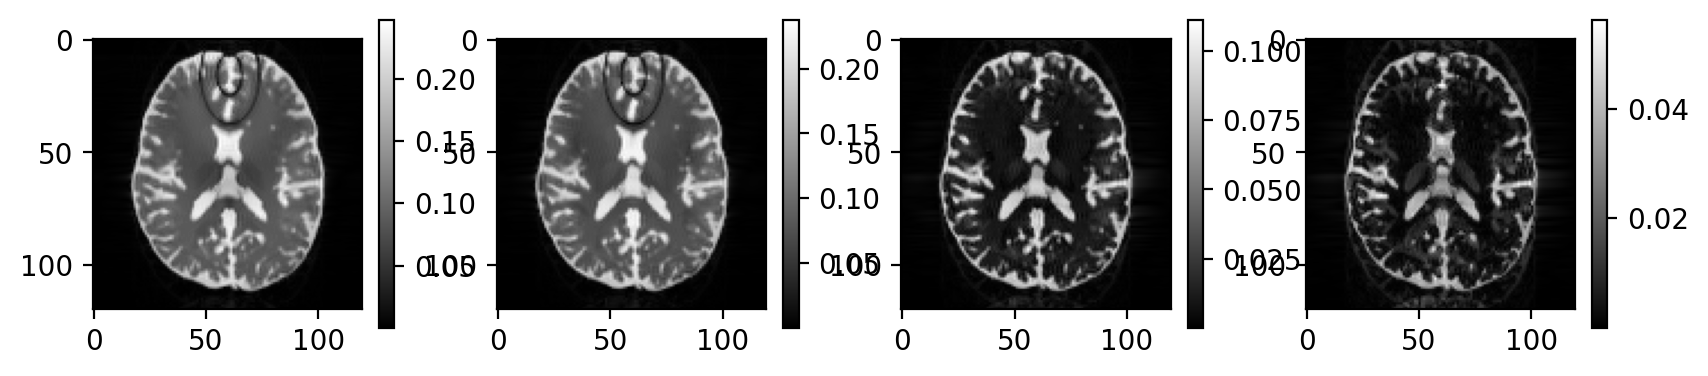

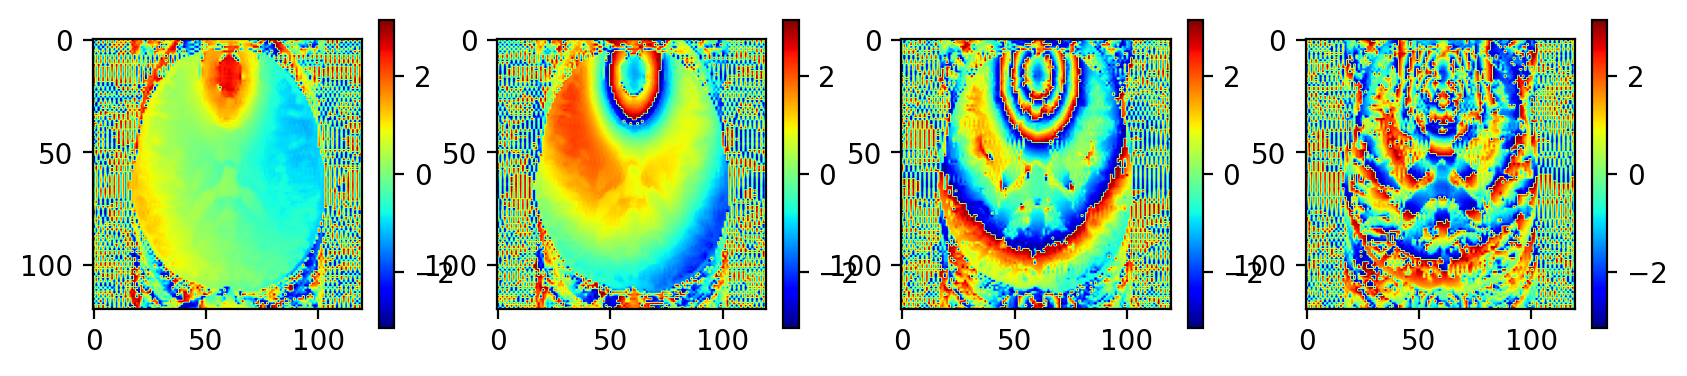

In [33]:
k_echo_p1 = k_space[:,:k_space.shape[1]//4]
k_echo_0 = k_space[:,k_space.shape[1]//4:k_space.shape[1]//2]
k_echo_n1 = k_space[:,k_space.shape[1]//2:3*k_space.shape[1]//4]
k_echo_n2 = k_space[:,3*k_space.shape[1]//4:]

m_p1 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_p1)))
m_0 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_0)))
m_n1 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_n1)))
m_n2 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_n2)))

plt.figure(figsize=(10, 2),dpi=200)
plt.subplot(141)
plt.imshow(np.abs(m_p1.numpy()), cmap="gray")
plt.colorbar()
plt.subplot(142)
plt.imshow(np.abs(m_0.numpy()), cmap="gray")
plt.colorbar()
plt.subplot(143)
plt.imshow(np.abs(m_n1.numpy()), cmap="gray")
plt.colorbar()
plt.subplot(144)
plt.imshow(np.abs(m_n2.numpy()), cmap="gray")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 2),dpi=200)
plt.subplot(141)
plt.imshow(np.angle(m_p1.numpy()), cmap="jet")
plt.colorbar()
plt.subplot(142)
plt.imshow(np.angle(m_0.numpy()), cmap="jet")
plt.colorbar()
plt.subplot(143)
plt.imshow(np.angle(m_n1.numpy()), cmap="jet")
plt.colorbar()
plt.subplot(144)
plt.imshow(np.angle(m_n2.numpy()), cmap="jet")
plt.colorbar()
plt.show()


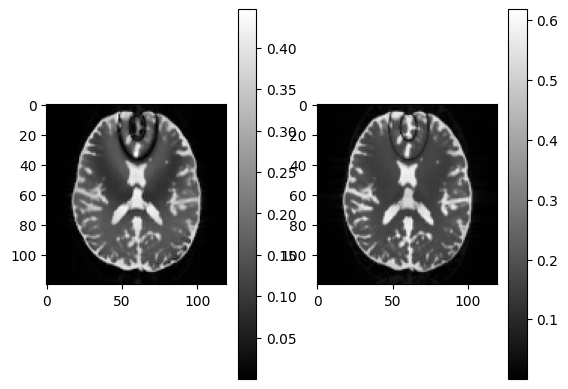

In [34]:
plt.subplot(1,2,1)
plt.imshow(np.abs((m_p1+m_0+m_n1+m_n2).numpy()), cmap="gray")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow((torch.abs(m_p1)+torch.abs(m_0)+torch.abs(m_n1)+torch.abs(m_n2)).numpy(), cmap="gray")
plt.colorbar()

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.002150683 s
Compute Graph
Computing Graph: 1.4309509 s
Analyze Graph
Analyzing Graph: 0.014103763 s


Converting Rust -> Python: 0.5112673 s
<<<< Rust <<<<


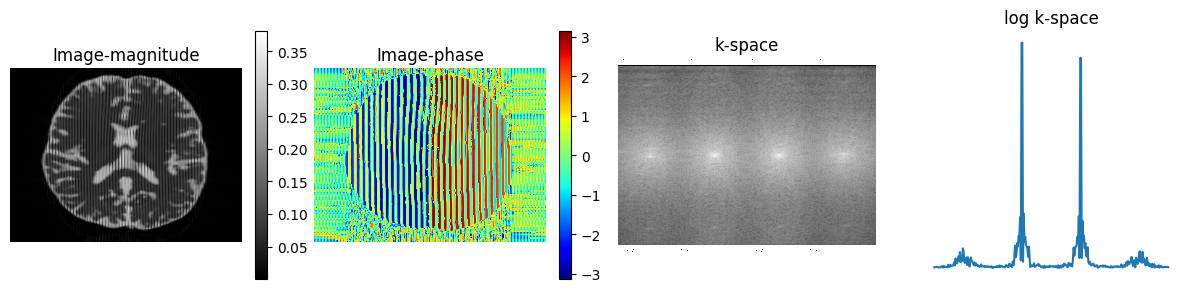

In [ ]:
# seq_path = "seq/bSSFP.seq"
seq_path = "seq/ubSSFP_1.33.seq"

seq = pp.Sequence()
seq.read(seq_path)
signal, _ = mr0.util.simulate(seq, phantom)

# k_space_size = np.sqrt(signal.size()[0]).astype(int)
# DESS
# k_space_size = np.sqrt(signal.size()[0]/2).astype(int)
# print(rf"K space size: {k_space_size}")
# print(signal.size())
# k_space = signal.reshape(k_space_size, k_space_size)
k_space = signal.reshape(phantom_size, -1)
spectrum = torch.fft.ifftshift(k_space)
space = torch.fft.ifft2(spectrum)
space = torch.fft.fftshift(space)

# Plot the result
fraction = 0.05

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].set_title('Image-magnitude')
ax0 = axes[0].imshow(np.abs(space.numpy()), cmap="gray")
fig.colorbar(ax0, ax=axes[0], fraction=fraction)

axes[1].set_title('Image-phase')
ax1 = axes[1].imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap="jet")
fig.colorbar(ax1, ax=axes[1], fraction=fraction)

axes[2].set_title('k-space')
ax2 = axes[2].imshow(np.abs(k_space.numpy()), cmap="gray", norm=LogNorm())

axes[3].set_title('log k-space')
# ax3 = axes[3].imshow(np.log(np.abs(k_space.numpy())), cmap=cmap)
# ax3 = axes[3].imshow(np.abs(k_space.numpy()), cmap="grya", norm=LogNorm())
ax3 = axes[3].plot(np.abs(k_space.numpy())[k_space.shape[0]//2,:])

for ax in axes:
    ax.axis("off")

fig.tight_layout()

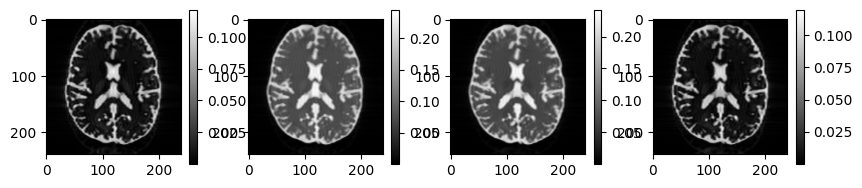

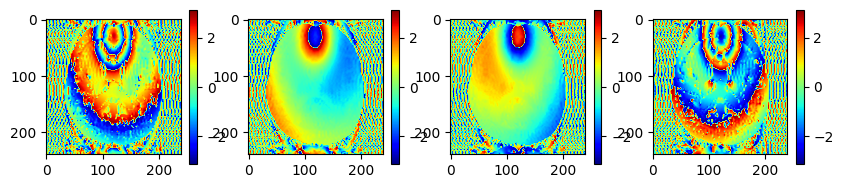

In [ ]:
import torch.nn.functional as F
k_space.shape



k_echo_p1 = k_space[:,:k_space.shape[1]//4]
k_echo_0 = k_space[:,k_space.shape[1]//4:k_space.shape[1]//2]
k_echo_n1 = k_space[:,k_space.shape[1]//2:3*k_space.shape[1]//4]
k_echo_n2 = k_space[:,3*k_space.shape[1]//4:]

k_echo_p1 = F.pad(k_echo_p1, (k_space.shape[1]//4, k_space.shape[1]//4), mode='constant', value=0)
k_echo_0 = F.pad(k_echo_0, (k_space.shape[1]//4, k_space.shape[1]//4), mode='constant', value=0)
k_echo_n1 = F.pad(k_echo_n1, (k_space.shape[1]//4, k_space.shape[1]//4), mode='constant', value=0)
k_echo_n2 = F.pad(k_echo_n2, (k_space.shape[1]//4, k_space.shape[1]//4), mode='constant', value=0)

m_p1 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_p1)))
m_0 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_0)))
m_n1 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_n1)))
m_n2 = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.ifftshift(k_echo_n2)))

plt.figure(figsize=(10, 2))
plt.subplot(141)
plt.imshow(np.abs(m_p1.numpy()), cmap="gray")
plt.colorbar()
plt.subplot(142)
plt.imshow(np.abs(m_0.numpy()), cmap="gray")
plt.colorbar()
plt.subplot(143)
plt.imshow(np.abs(m_n1.numpy()), cmap="gray")
plt.colorbar()
plt.subplot(144)
plt.imshow(np.abs(m_n2.numpy()), cmap="gray")
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 2))
plt.subplot(141)
plt.imshow(np.angle(m_p1.numpy()), cmap="jet")
plt.colorbar()
plt.subplot(142)
plt.imshow(np.angle(m_0.numpy()), cmap="jet")
plt.colorbar()
plt.subplot(143)
plt.imshow(np.angle(m_n1.numpy()), cmap="jet")
plt.colorbar()
plt.subplot(144)
plt.imshow(np.angle(m_n2.numpy()), cmap="jet")
plt.colorbar()
plt.show()


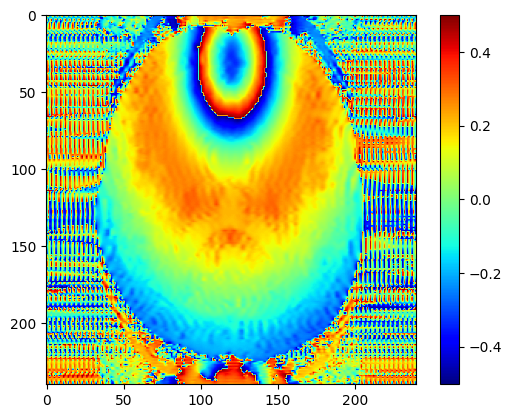

In [ ]:
from skimage.restoration import unwrap_phase
TE_p1 = 2.69 # ms
TE_0 = 2.77 # ms
TE_n1 = 2.85 # ms
TE_n2 = 2.93 # ms
TR = 6.34 # ms
plt.imshow((torch.angle(m_0*m_n1.conj()).numpy())/(TE_n1-TE_0-TR), cmap="jet")
plt.imshow((torch.angle(m_0*m_n1.conj()).numpy())/(TE_n1-TE_0-TR), cmap="jet")
plt.colorbar()

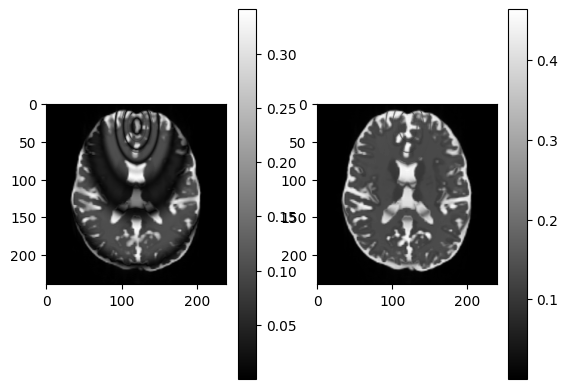

In [25]:
plt.subplot(1,2,1)
plt.imshow(np.abs((m_p1+m_0+m_n1+m_n2).numpy()), cmap="gray")
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow((torch.abs(m_p1)+torch.abs(m_0)+torch.abs(m_n1)+torch.abs(m_n2)).numpy(), cmap="gray")
plt.colorbar()